In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
from astropy.timeseries import LombScargle
from astropy.timeseries import LombScargleMultiband
from timeit import timeit
from functools import partial

### Periodograms

In [35]:
data_global = pd.read_pickle("../../PeriodogramsGaia/dataset/data_global.pkl")

In [25]:
# def periodograms_band(lc,period, d_folder_lc, freq):
#     times, fluxs, ferrs, bands = [], [], [], []
#     dict_per = {}
#     for (name, data) in lc.groupby("band"):
#         band = data['band'].iloc[0]
#         mask = data["rejected_by_variability"]=="false"
#         time, flux, flux_err =data.loc[mask][['time', 'flux', 'flux_error']].values.T
#         per = LombScargle(time, flux, flux_err).power(freq)
#         dict_per[name] = per
#         # multiband
#         times += list(time)
#         fluxs += list(flux)
#         ferrs += list(flux_err)
#         bands += [name]*len(flux)

#     per = LombScargleMultiband(times, fluxs, bands, ferrs).power(freq)
#     dict_per['multiband'] = per
    
#     with open(d_folder_lc + '/periodograms.pkl', 'wb') as handle:
#         pkl.dump(dict_per, handle, protocol=pkl.HIGHEST_PROTOCOL)
    

In [1]:
import ray

2024-09-15 01:37:44,296	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [36]:
@ray.remote(num_cpus=4)
def periodograms_band(freq, d_folder_type, folder_lc):

    # para que no entre en el archivo de las freq
    d_folder_lc = os.path.join(d_folder_type, folder_lc)
    lc = pd.read_pickle(os.path.join(d_folder_lc, folder_lc+'.pkl'))
    name_lc = lc.source_id.iloc[0]
    period = data_global[data_global.index == name_lc].values[0][0]
    #periodograms_band(lc, period,d_folder_lc, freq)

    times, fluxs, ferrs, bands = [], [], [], []
    dict_per = {}
    for (name, data) in lc.groupby("band"):
        band = data['band'].iloc[0]
        mask = data["rejected_by_variability"]=="false"
        time, flux, flux_err =data.loc[mask][['time', 'flux', 'flux_error']].values.T
        per = LombScargle(time, flux, flux_err).power(freq)
        dict_per[name] = per
        # multiband
        times += list(time)
        fluxs += list(flux)
        ferrs += list(flux_err)
        bands += [name]*len(flux)

    per = LombScargleMultiband(times, fluxs, bands, ferrs).power(freq)
    dict_per['multiband'] = per
    
    return d_folder_lc, dict_per

In [37]:
ray.init()

2024-07-31 16:08:14,987	INFO worker.py:1752 -- Started a local Ray instance.


Python version:,3.11.8
Ray version:,2.10.0


In [38]:
directory = '../dataset'
repetitions = 1

for folder_type in os.listdir(directory):
    #../dataset/ECL
    d_folder_type = os.path.join(directory, folder_type)
    if folder_type == "ECL":
        freq = np.arange(0.001473, 2*4.999929 , 1e-4)
        with open('../dataset/'+folder_type+'/frequencies_'+folder_type+'.pkl', 'wb') as handle:
            pkl.dump(freq, handle, protocol=pkl.HIGHEST_PROTOCOL)
    elif folder_type == "RR":
        freq = np.arange(1.00061, 2*4.973236 , 1e-4)
        with open('../dataset/'+folder_type+'/frequencies_'+folder_type+'.pkl', 'wb') as handle:
            pkl.dump(freq, handle, protocol=pkl.HIGHEST_PROTOCOL)



    # para que no entre en el dataglobal
    if folder_type.find('.') == -1:
        #periodograms_band_paralell = periodograms_band.options(scheduling_strategy='DEFAULT')
        results = ray.get([periodograms_band.remote(freq, d_folder_type, folder_lc) for folder_lc in os.listdir(d_folder_type) if folder_lc.find('.') == -1])
        #results = [periodograms_band(freq, d_folder_type, folder_lc) for folder_lc in os.listdir(d_folder_type) if folder_lc.find('.') == -1]

        if folder_type == "ECL":
            profile = partial(timeit, globals=globals(), number=repetitions)
            time_ECL = profile("ray.get([periodograms_band.remote(freq, d_folder_type, folder_lc) for folder_lc in os.listdir(d_folder_type) if folder_lc.find('.') == -1])")
        elif folder_type == "RR":
            profile = partial(timeit, globals=globals(), number=repetitions)
            time_RR = profile("ray.get([periodograms_band.remote(freq, d_folder_type, folder_lc) for folder_lc in os.listdir(d_folder_type) if folder_lc.find('.') == -1])")

        for result in results:
            with open(result[0] + '/periodograms.pkl', 'wb') as handle:
                pkl.dump(result[1], handle, protocol=pkl.HIGHEST_PROTOCOL)
                
print(f"Time: {(time_ECL+time_RR)/repetitions:0.4f} s")


(raylet) [2024-07-31 16:08:24,857 E 152233 152255] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-31_16-08-12_470919_4972 is over 95% full, available space: 10009460736; capacity: 217109245952. Object creation will fail if spilling is required.
(raylet) [2024-07-31 16:08:34,864 E 152233 152255] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-31_16-08-12_470919_4972 is over 95% full, available space: 10009456640; capacity: 217109245952. Object creation will fail if spilling is required.
(raylet) [2024-07-31 16:08:44,874 E 152233 152255] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-31_16-08-12_470919_4972 is over 95% full, available space: 10009423872; capacity: 217109245952. Object creation will fail if spilling is required.
(raylet) [2024-07-31 16:08:54,881 E 152233 152255] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-31_16-08-12_470919_4972 is over 95% full, available space: 10009403392; capacity: 217109245952. Object crea

KeyboardInterrupt: 

In [39]:
ray.shutdown()

## Speed up
Curva de speed up, es decir tiempo single core versus tiempo multi core, para 10, 100 y 1000 curvas. Para ver qué tan eficiente es la paralización

without_paralelizated = [222.3017, 2435.1066, 22825.1152]
single_core = [105.1584, 918.6795, 9927.0636]
1 core = [121.2573, 994.8535, este2] calculado 10750,1843
2 core multi_core = [118.0450, 973.5083, este1]
4 core = [149.8708, 1429.6909, estemejor]
8 core = [213.9751, ]

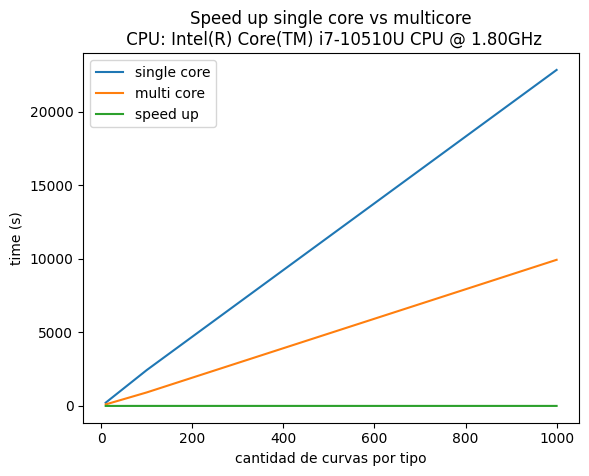

In [40]:
single_core = [222.3017, 2435.1066, 22825.1152]
multi_core = [105.1584, 918.6795, 9927.0636]
cpu = "Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz"
spped_up = [single_core[i]/multi_core[i] for i in range(len(single_core))]
curves = [10, 100, 1000]

fig, ax = plt.subplots()
ax.plot(curves, single_core, label="single core")
ax.plot(curves, multi_core, label="multi core")
ax.plot(curves, spped_up, label="speed up")
ax.legend()
ax.set_title("Speed up single core vs multicore\n CPU: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz")
ax.set_xlabel("cantidad de curvas por tipo")
ax.set_ylabel("time (s)")

plt.show()

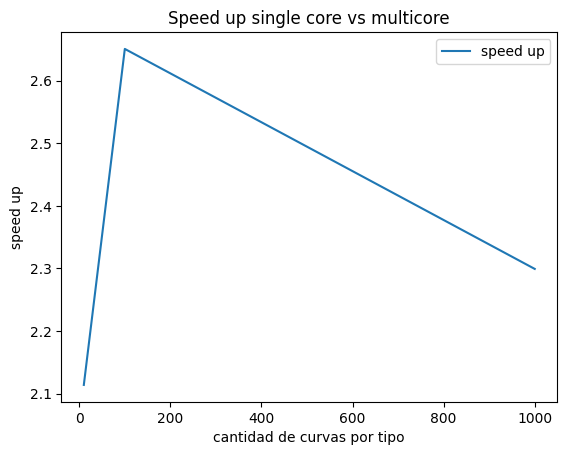

In [4]:
speed_up = [single_core[i]/multi_core[i] for i in range(len(single_core))]
curves = [10, 100, 1000]

fig, ax = plt.subplots()
ax.plot(curves, speed_up, label="speed up")
ax.legend()
ax.set_title("Speed up single core vs multicore")
ax.set_xlabel("cantidad de curvas por tipo")
ax.set_ylabel("speed up")

plt.show()

In [29]:
@ray.remote
def periodograms_band(freq, d_folder_type, folder_lc):

    # para que no entre en el archivo de las freq
    d_folder_lc = os.path.join(d_folder_type, folder_lc)
    lc = pd.read_pickle(os.path.join(d_folder_lc, folder_lc+'.pkl'))
    name_lc = lc.source_id.iloc[0]
    period = data_global[data_global.index == name_lc].values[0][0]
    #periodograms_band(lc, period,d_folder_lc, freq)

    times, fluxs, ferrs, bands = [], [], [], []
    dict_per = {}
    for (name, data) in lc.groupby("band"):
        band = data['band'].iloc[0]
        mask = data["rejected_by_variability"]=="false"
        time, flux, flux_err =data.loc[mask][['time', 'flux', 'flux_error']].values.T
        per = LombScargle(time, flux, flux_err).power(freq)
        dict_per[name] = per
        # multiband
        times += list(time)
        fluxs += list(flux)
        ferrs += list(flux_err)
        bands += [name]*len(flux)

    per = LombScargleMultiband(times, fluxs, bands, ferrs).power(freq)
    dict_per['multiband'] = per
    
    return d_folder_lc, dict_per

In [30]:
ray.init()

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [ ]:
directory = '../dataset'

repetitions = 1

for folder_type in os.listdir(directory):
    #../dataset/ECL
    d_folder_type = os.path.join(directory, folder_type)
    if folder_type == "ECL":
        freq = np.arange(0.001473, 2*4.999929 , 1e-4)
        with open('../dataset/'+folder_type+'/frequencies_'+folder_type+'.pkl', 'wb') as handle:
            pkl.dump(freq, handle, protocol=pkl.HIGHEST_PROTOCOL)
    elif folder_type == "RR":
        freq = np.arange(1.00061, 2*4.973236 , 1e-4)
        with open('../dataset/'+folder_type+'/frequencies_'+folder_type+'.pkl', 'wb') as handle:
            pkl.dump(freq, handle, protocol=pkl.HIGHEST_PROTOCOL)



    # para que no entre en el dataglobal
    if folder_type.find('.') == -1:
        results = ray.get([periodograms_band.remote(freq, d_folder_type, folder_lc) for folder_lc in os.listdir(d_folder_type) if folder_lc.find('.') == -1])
        if folder_type == "ECL":
            profile = partial(timeit, globals=globals(), number=repetitions)
            time_ECL = profile("ray.get([periodograms_band.remote(freq, d_folder_type, folder_lc) for folder_lc in os.listdir(d_folder_type) if folder_lc.find('.') == -1])")
        elif folder_type == "RR":
            profile = partial(timeit, globals=globals(), number=repetitions)
            time_RR = profile("ray.get([periodograms_band.remote(freq, d_folder_type, folder_lc) for folder_lc in os.listdir(d_folder_type) if folder_lc.find('.') == -1])")

        for result in results:
            with open(result[0] + '/periodograms.pkl', 'wb') as handle:
                pkl.dump(result[1], handle, protocol=pkl.HIGHEST_PROTOCOL)

print(f"Time: {(time_ECL+time_RR)/repetitions:0.4f} s")

KeyboardInterrupt: 

2024-05-28 17:31:32,469	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::periodograms_band() (pid=21088, ip=192.168.0.16)
  File "/tmp/ipykernel_14757/429676165.py", line 6, in periodograms_band
  File "/home/naye/miniconda3/envs/ray/lib/python3.11/site-packages/pandas/io/pickle.py", line 185, in read_pickle
    with get_handle(
         ^^^^^^^^^^^
  File "/home/naye/miniconda3/envs/ray/lib/python3.11/site-packages/pandas/io/common.py", line 882, in get_handle
    handle = open(handle, ioargs.mode)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '../dataset/ECL/709709093301608448/709709093301608448.pkl'
2024-05-28 17:31:32,496	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::periodograms_band() (pid=21088, ip=192.168.0.16)
  File "/tmp/ipykernel_14757/429676165.py", line 6, in periodograms_band
  File "/home/naye/miniconda3/envs/ray/lib/python3.11/site

In [ ]:
ray.shutdown()